# Data source

The common data elements for predictive maintenance problems can be summarized as follows:

* Machine features: The features of a machine, e.g. engine size, make and model, location.
* Operator features: The features of the operator, e.g. gender, past experience.
* Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
* Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
* Failure history: The failure history of a machine or component within the machine.

It is possible and usually the case that failure history is contained in maintenance history such as in the form of special error codes or order dates for spare parts. In those cases, failures can be extracted from the maintenance data. Additionally, different business domains may have a variety of other data sources that influence failure patterns which are not listed here exhaustively. These should be identified by consulting the domain experts when building predictive models.

Some examples of above data elements from use cases are:
    
**Machine conditions and usage:** Flight routes and times, sensor data collected from aircraft engines, sensor readings from ATM transactions, train events data, sensor readings from wind turbines, elevators and connected cars.
    
**Machine features:** Circuit breaker technical specifications such as voltage levels, geolocation or car features such as make, model, engine size, tire types, production facility etc.

**Failure history:** fight delay dates, aircraft component failure dates and types, ATM cash withdrawal transaction failures, train/elevator door failures, brake disk replacement order dates, wind turbine failure dates and circuit breaker command failures.

**Maintenance history:** Flight error logs, ATM transaction error logs, train maintenance records including maintenance type, short description etc. and circuit breaker maintenance records.

Given the above data sources, the two main data types we observe in predictive maintenance domain are temporal data and static data. Failure history, machine conditions, repair history, usage history almost always come with time-stamps indicating the time of collection for each piece of data. Machine features and operator features in general are static since they usually describe the technical specifications of machines or operator’s properties. It is possible for these features to change over time and if so they should be treated as time stamped data sources.

# Step 1: Data Aquisition

The data aquisiton notebook will download the simulated predicitive maintenance data sets from our GitHub store. Do some preliminary data cleaning and verification, and store the results in an Azure Blob storage container for use in the remaining steps of this analysis.

**Note:** This notebook will take about 10-15 minutes to execute all cells, depending on the compute configuration you have setup. Most of this time is spent handling the _telemetry_ data set, which contains about 8.7 million records.

In [5]:
## Setup our environment by importing required libraries
import time
import os
import glob
import urllib

# Read csv file from URL directly
import pandas as pd

# For Azure blob storage access
from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

# For creating some preliminary EDA plots.
%matplotlib inline
import matplotlib.pyplot as plt
from ggplot import *

# Setup the pyspark environment
from pyspark.sql import SparkSession

# For logging model evaluation parameters back into the
# AML Workbench run history plots.
import logging
from azureml.logging import get_azureml_logger

amllog = logging.getLogger("azureml")
amllog.level = logging.INFO

# Turn on cell level logging.
%azureml history on
%azureml history show

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
tic = time.time()

logger = get_azureml_logger() # logger writes to AMLWorkbench runtime view
spark = SparkSession.builder.getOrCreate()

History logging enabled
History logging is enabled


## Azure Blob Storage Container

We will be storing intermediate results for use between these Jupyter notebooks in an Azure Blob Storage container. Instructions for setting up your Azure Storage account are available within this link (https://docs.microsoft.com/en-us/azure/storage/blobs/storage-python-how-to-use-blob-storage). You will need to copy your account name and account key from the _Access Keys_ area in the portal into the following code block. These credentials will be reused in all four Jupyter notebooks. 

We will handle creating the containers and writing the data to these containers for each notebook. Further instructions for using Azure Blob storage with AML Workbench are available
(https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md).

You will need to enter the **ACCOUNT_NAME** as well as the **ACCOUNT_KEY** in order to access Azure Blob storage account you have created. This notebook will create and store all the resulting data files in a blob container under this account. 


In [6]:
# Enter your Azure blob storage details here 
ACCOUNT_NAME = "<your blob storage account name>"

# You can find the account key under the _Access Keys_ link in the 
# [Azure Portal](portal.azure.com) page for your Azure storage container.
ACCOUNT_KEY = "<your blob storage account key>"

#-------------------------------------------------------------------------------------------
# We will create this container to hold the results of executing this notebook.
# If this container name already exists, we will use that instead, however
# This notebook will ERASE ALL CONTENTS.
CONTAINER_NAME = "dataingestion"

# Connect to your blob service     
az_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

# Create a new container if necessary, otherwise you can use an existing container.
# This command creates the container if it does not already exist. Else it does nothing.
az_blob_service.create_container(CONTAINER_NAME, 
                                 fail_on_exist=False, 
                                 public_access=PublicAccess.Container)

False

## Download simulated data sets
We will be reusing the raw simulated data files from another tutorial. The notebook automatically downloads these files stored at [Microsoft/SQL-Server-R-Services-Samples GitHub site](https://github.com/Microsoft/SQL-Server-R-Services-Samples/tree/master/PredictiveMaintanenceModelingGuide/Data).

The five data files are:

    * machines.csv
    * maint.csv
    * errors.csv
    * telemetry.csv
    * failures.csv
    
This notebook does some preliminary cleanup, creates a summary graphic for each data set to verify the data download, and stores the resulting data sets in the Azure blob container created in the previous section.

In [7]:
# The raw data is stored on GitHub here:
basedataurl = "http://media.githubusercontent.com/media/Microsoft/SQL-Server-R-Services-Samples/master/PredictiveMaintanenceModelingGuide/Data/"

# We will store each of these data sets in blob storage in an 
# Azure Storage Container on your Azure subscription.
# See https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md
# for details.

# These file names detail which blob each files is stored under. 
MACH_DATA = 'machines_files.parquet'
MAINT_DATA = 'maint_files.parquet'
ERROR_DATA = 'errors_files.parquet'
TELEMETRY_DATA = 'telemetry_files.parquet'
FAILURE_DATA = 'failure_files.parquet'


## Machines data set

This simulation tracks a simulated set of 1000 machines over the course of a single year (2015). 

This data set includes information about each machine: Machine ID, model type and age (years in service). 

In [8]:
# load raw data from the GitHub URL
datafile = "machines.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
machines = pd.read_csv(datafile, encoding='utf-8')

print(machines.count())
machines.head(10)

machineID    1000
model        1000
age          1000
dtype: int64


,machineID,model,age
0,1,model2,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model2,2
5,6,model3,7
6,7,model4,20
7,8,model3,16
8,9,model1,7
9,10,model1,10


The following figure plots a histogram of the machines age colored by the specific model.

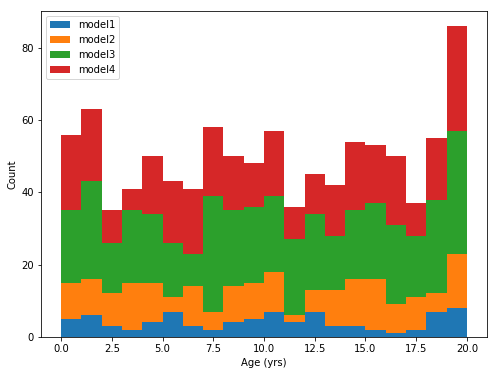

In [9]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

The figure shows how long the collection of machines have been in service.

Next, we convert the machines data to PySpark and store it in an Azure blob.

In [10]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
mach_spark = spark.createDataFrame(machines, 
                                   verifySchema=False)

# Write the Machine data set to intermediate storage
mach_spark.write.mode('overwrite').parquet(MACH_DATA)

for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MACH_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(MACH_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Machines files saved!")

del machines

/azureml-run/machines_files.parquet/part-00004-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
/azureml-run/machines_files.parquet/part-00007-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
/azureml-run/machines_files.parquet/part-00006-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
/azureml-run/machines_files.parquet/part-00005-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
/azureml-run/machines_files.parquet/part-00000-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
/azureml-run/machines_files.parquet/part-00003-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
/azureml-run/machines_files.parquet/_SUCCESS
/azureml-run/machines_files.parquet/part-00001-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
/azureml-run/machines_files.parquet/part-00002-62bdd5ea-b1fc-41ac-becc-051c7fa85416.snappy.parquet
Machines files saved!


## Errors  data set

The error log contains non-breaking errors recorded while the machine is still operational. These errors are not considered failures, though they may be predictive of a future failure event. The error datetime field is rounded to the closest hour since the telemetry data (loaded later) is collected on an hourly rate.

In [11]:
# load raw data from the GitHub URL
datafile = "errors.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
errors = pd.read_csv(datafile, encoding='utf-8')

print(errors.count())
errors.head(10)

datetime     11967
machineID    11967
errorID      11967
dtype: int64


,datetime,machineID,errorID
0,2015-01-06 03:00:00,1,error3
1,2015-02-03 06:00:00,1,error4
2,2015-02-21 11:00:00,1,error1
3,2015-02-21 16:00:00,1,error2
4,2015-03-20 06:00:00,1,error1
5,2015-04-04 06:00:00,1,error5
6,2015-05-04 06:00:00,1,error4
7,2015-05-19 06:00:00,1,error2
8,2015-05-19 06:00:00,1,error3
9,2015-06-03 06:00:00,1,error5


The following histogram details the distribution of the errors tracked in the log files. 

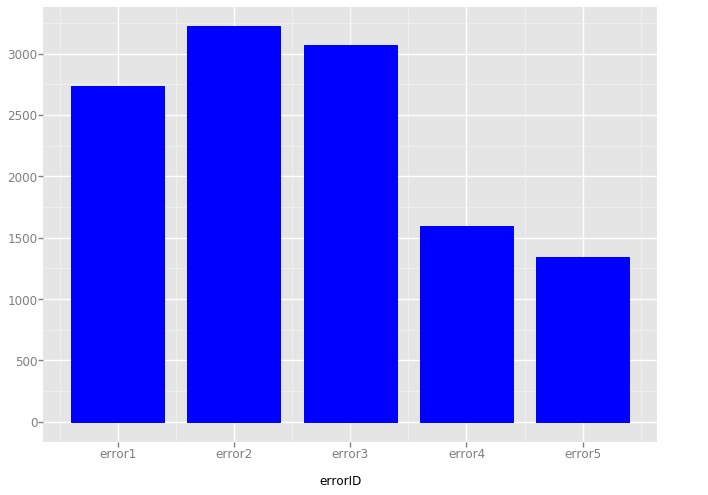

<ggplot: (8760602013090)>

In [12]:
# Quick plot to show structure
ggplot(aes(x="errorID"), errors) + geom_bar(fill="blue", color="black")

The figure shows how many errors occured in each of the 5 error classes over the entire year.

Next, we convert the errors data to PySpark and store it in an Azure blob.

In [13]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
error_spark = spark.createDataFrame(errors, 
                               verifySchema=False)

# Write the Errors data set to intermediate storage
error_spark.write.mode('overwrite').parquet(ERROR_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if ERROR_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(ERROR_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Errors files saved!")

del errors

/azureml-run/errors_files.parquet/part-00003-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
/azureml-run/errors_files.parquet/part-00006-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
/azureml-run/errors_files.parquet/_SUCCESS
/azureml-run/errors_files.parquet/part-00002-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
/azureml-run/errors_files.parquet/part-00005-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
/azureml-run/errors_files.parquet/part-00001-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
/azureml-run/errors_files.parquet/part-00004-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
/azureml-run/errors_files.parquet/part-00007-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
/azureml-run/errors_files.parquet/part-00000-d1190a46-f95a-4981-b06c-229072ac85a8.snappy.parquet
Errors files saved!


## Maintenance data set

The maintenance log contains both scheduled and unscheduled maintenance records. Scheduled maintenance corresponds with  regular inspection of components, unscheduled maintenance may arise from mechanical failure or other performance degradations. A failure record is generated for component replacement in the case  of either maintenance events. Because maintenance events can also be used to infer component life, the maintenance data has been collected over two years (2014, 2015) instead of only over the year of interest (2015).

In [14]:
# load raw data from the GitHub URL
datafile = "maint.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
maint = pd.read_csv(datafile, encoding='utf-8')

print(maint.count())
maint.head(20)

datetime     32592
machineID    32592
comp         32592
dtype: int64


,datetime,machineID,comp
0,2014-07-01 06:00:00,1,comp4
1,2014-09-14 06:00:00,1,comp1
2,2014-09-14 06:00:00,1,comp2
3,2014-11-13 06:00:00,1,comp3
4,2015-01-05 06:00:00,1,comp1
5,2015-01-20 06:00:00,1,comp1
6,2015-02-04 06:00:00,1,comp3
7,2015-02-19 06:00:00,1,comp3
8,2015-03-06 06:00:00,1,comp3
9,2015-03-21 06:00:00,1,comp1


The following histogram details the distribution of the maintenance records tracked in the maintenance log file. 

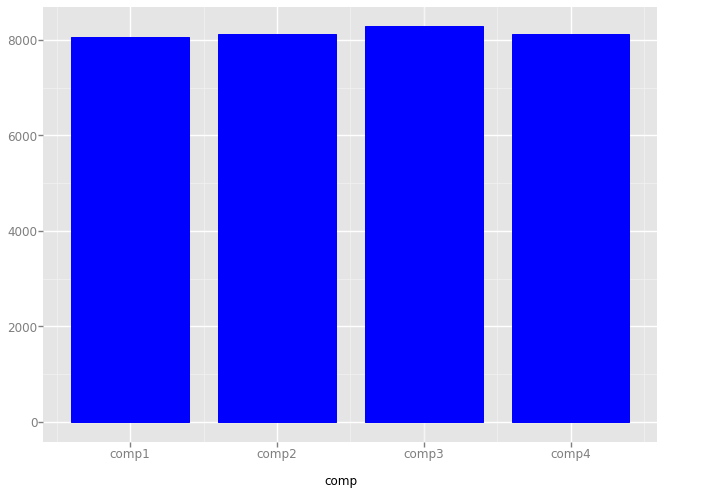

<ggplot: (8760602141041)>

In [15]:
# Quick plot to show structure
ggplot(aes(x="comp"), maint) + geom_bar(fill="blue", color="black")

The figure shows component replacements occured for each of the 4 component types over the entire year.

Next, we convert the maintenance data to PySpark and store it in an Azure blob.

In [16]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
maint_spark = spark.createDataFrame(maint, 
                              verifySchema=False)

# Write the Maintenance data set to intermediate storage
maint_spark.write.mode('overwrite').parquet(MAINT_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MAINT_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(MAINT_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Maintenance files saved!")

del maint

/azureml-run/maint_files.parquet/part-00006-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
/azureml-run/maint_files.parquet/part-00005-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
/azureml-run/maint_files.parquet/part-00004-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
/azureml-run/maint_files.parquet/_SUCCESS
/azureml-run/maint_files.parquet/part-00002-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
/azureml-run/maint_files.parquet/part-00007-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
/azureml-run/maint_files.parquet/part-00001-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
/azureml-run/maint_files.parquet/part-00003-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
/azureml-run/maint_files.parquet/part-00000-8d8f86b7-a91b-48a6-b297-03d0baec543f.snappy.parquet
Maintenance files saved!


## Telemetry data set

The telemetry time-series data consists of voltage, rotation, pressure, and vibration sensor measurements collected from each  machines in real time. The data is averaged over an hour and stored in the telemetry logs.

In [17]:
# load raw data from the GitHub URL
datafile = "telemetry.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
telemetry = pd.read_csv(datafile, encoding='utf-8')

# handle missing values
# define groups of features 
features_datetime = ['datetime']
features_categorical = ['machineID']
features_numeric = list(set(telemetry.columns) - set(features_datetime) - set(features_categorical))

# Replace numeric NA with 0
telemetry[features_numeric] = telemetry[features_numeric].fillna(0)

# Replace categorical NA with 'Unknown'
telemetry[features_categorical]  = telemetry[features_categorical].fillna("Unknown")

print(telemetry.count())
telemetry.head(10)

datetime     8761000
machineID    8761000
volt         8761000
rotate       8761000
pressure     8761000
vibration    8761000
dtype: int64


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,1,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,1,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,1,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,1,180.544277,371.600611,107.553307,41.467880
5,2015-01-01 11:00:00,1,141.411757,530.857266,87.614001,44.985846
6,2015-01-01 12:00:00,1,184.083822,450.227529,87.697380,30.831263
7,2015-01-01 13:00:00,1,166.632618,486.466838,108.067734,50.380054
8,2015-01-01 14:00:00,1,159.892748,488.968697,102.131884,43.661297
9,2015-01-01 15:00:00,1,176.686812,508.202759,90.951189,43.039696


Rather than plot 8.7 million data points, this figure plots a month of voltage measurements for a single machine. This is representative of each feature repeated for every machine.

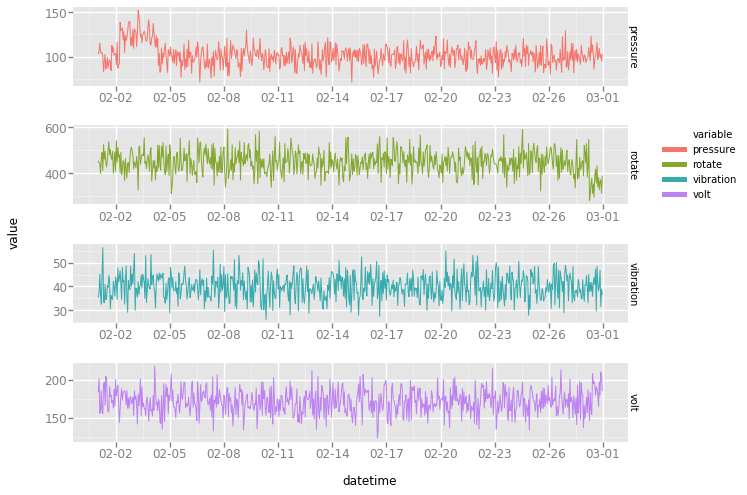

<ggplot: (-9223363276226815351)>

In [18]:
# Quick plot to show structure
plt_data = telemetry

# format datetime field which comes in as string
plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")

plot_df = plt_data.loc[(plt_data['machineID'] == 1) &
                        (plt_data['datetime'] > pd.to_datetime('2015-02-01')) &
                        (plt_data['datetime'] < pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

ggplot(aes(x="datetime", y="value", color = "variable", group="variable"), plt_data) +\
    scale_x_date(labels=date_format('%m-%d')) +\
    geom_line() +\
    facet_grid('variable', scales='free_y')


The figure shows one month worth of telemetry sensor data for one machine. Each sensor is shown in it's own panel.

Next, we convert the telemetry data to PySpark and store it in an Azure blob.

In [19]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.

# Explicitly converty datetime to string for spark DF.
telemetry['datetime'] = telemetry['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

# Convert pandas to spark # This line takes about 9.5 minutes to run.
telemetry_spark = spark.createDataFrame(telemetry, verifySchema=False)

# Write the telemetry data set to intermediate storage
telemetry_spark.write.mode('overwrite').parquet(TELEMETRY_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if TELEMETRY_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(TELEMETRY_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Telemetry files saved!")

# Clear memory
del telemetry
del plt_data
del plot_df

/azureml-run/telemetry_files.parquet/part-00002-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00004-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00003-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00006-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
/azureml-run/telemetry_files.parquet/_SUCCESS
/azureml-run/telemetry_files.parquet/part-00005-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00001-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00000-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00007-16ba6d96-e4a2-4230-96ed-098877d10c9d.snappy.parquet
Telemetry files saved!


## Failures data set

Failures correspond to component replacements within the maintenance log. Each record contains the Machine ID, component type, and replacement datetime. These records will be used to create the machine learning labels we will be trying to predict.

In [20]:
# load raw data from the GitHub URL
datafile = "failures.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
failures = pd.read_csv(datafile, encoding='utf-8')

print(failures.count())
failures.head(10)

datetime     6726
machineID    6726
failure      6726
dtype: int64


,datetime,machineID,failure
0,2015-02-04 06:00:00,1,comp3
1,2015-03-21 06:00:00,1,comp1
2,2015-04-05 06:00:00,1,comp4
3,2015-05-05 06:00:00,1,comp3
4,2015-05-20 06:00:00,1,comp2
5,2015-06-04 06:00:00,1,comp4
6,2015-06-19 06:00:00,1,comp2
7,2015-08-03 06:00:00,1,comp3
8,2015-08-03 06:00:00,1,comp4
9,2015-11-01 06:00:00,1,comp4


The following histogram details the distribution of the failure records obtained from failure log. This log was built originally from component replacements the maintenance log file. 

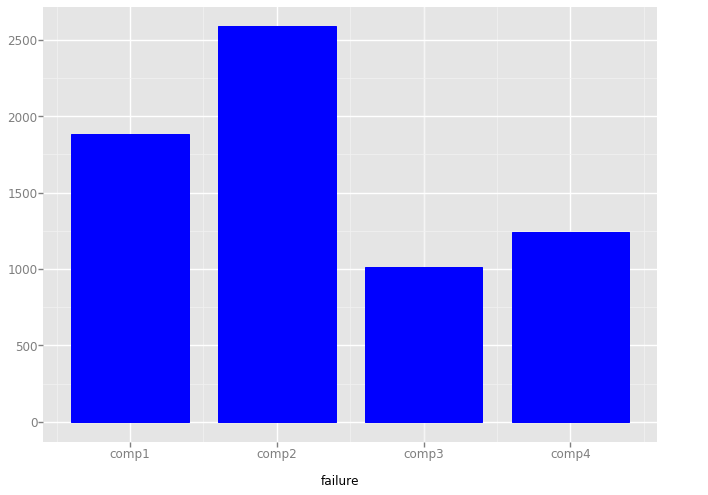

<ggplot: (8760601655602)>

In [21]:
# Plot failures
ggplot(aes(x="failure"), failures) + geom_bar(fill="blue", color="black")


The figure shows failure related replacements occured for each of the 4 component types over the entire year.

Next, we convert the maintenance data to PySpark and store it in an Azure blob.

In [22]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
failures_spark = spark.createDataFrame(failures, 
                                 verifySchema=False)

# Write the failures data set to intermediate storage
failures_spark.write.mode('overwrite').parquet(FAILURE_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if FAILURE_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(FAILURE_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Failure files saved!")

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
toc = time.time()
print("Full run took %.2f minutes" % ((toc - tic)/60))

logger.log("Data Ingestion Run time", ((toc - tic)/60))

/azureml-run/failure_files.parquet/part-00000-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
/azureml-run/failure_files.parquet/part-00004-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
/azureml-run/failure_files.parquet/part-00002-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
/azureml-run/failure_files.parquet/_SUCCESS
/azureml-run/failure_files.parquet/part-00001-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
/azureml-run/failure_files.parquet/part-00003-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
/azureml-run/failure_files.parquet/part-00007-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
/azureml-run/failure_files.parquet/part-00005-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
/azureml-run/failure_files.parquet/part-00006-d572b26a-4850-423e-b3f2-afa33280450e.snappy.parquet
Failure files saved!
Full run took 12.03 minutes


## Conclusion

We have now downloaded the required data files, and saved them into an Azure Blob storage container for use in the next step. The `Code\2_feature_engineering.ipynb` Jupyter notebook will read these data files in from Azure blob and generate the modeling features for out predictive maintnance machine learning model.